# Transformer Based视觉骨架网络

Minimal,  System, Insight, Programming

---

**课程内容**：

1. 掌握VIT设计理念
2. 掌握SwinTransformer设计理念
3. 掌握ConvNext设计理念
4. 通过代码实践，掌握主流Transformer Based 视觉网络建模方式，训练流程，采用预训练权重，对比不同网络精度

# VIT

ViT（vision transformer）是Google在2020年提出的直接将transformer应用在图像分类的模型，后面很多的工作都是基于ViT进行改进的。ViT的思路是：直接把图像分成固定大小的patchs，然后通过线性变换得到patch embedding，这就类比NLP的words和word embedding，由于transformer的输入就是a sequence of token embeddings，所以将图像的patch embeddings送入transformer后就能够进行特征提取从而实现分类。

ViT原论文中最核心的结论是，当拥有足够多的数据进行预训练的时候，ViT的表现就会超过CNN，突破transformer缺少归纳偏置的限制，可以在下游任务中获得较好的迁移效果。

但是当训练数据集不够大的时候，ViT的表现通常比同等大小的ResNets要差一些，因为Transformer和CNN相比缺少归纳偏置（inductive bias），即先验知识，提前做好的假设。CNN具有两种归纳偏置，一种是局部性（locality/two-dimensional neighborhood structure），即图片上相邻的区域具有相似的特征；一种是平移不变形（translation equivariance） 。CNN具有以上两种归纳偏置，就有了很多先验信息，需要相对少的数据就可以学习一个比较好的模型

## ViT的结构

ViT的核心流程包括图像分块处理 (make patches)、图像块嵌入 (patch embedding)与位置编码、Transformer编码器和MLP分类处理等4个主要部分。下面分别从这四个部分来阐述ViT的基本设计。ViT模型整体结构如图所示

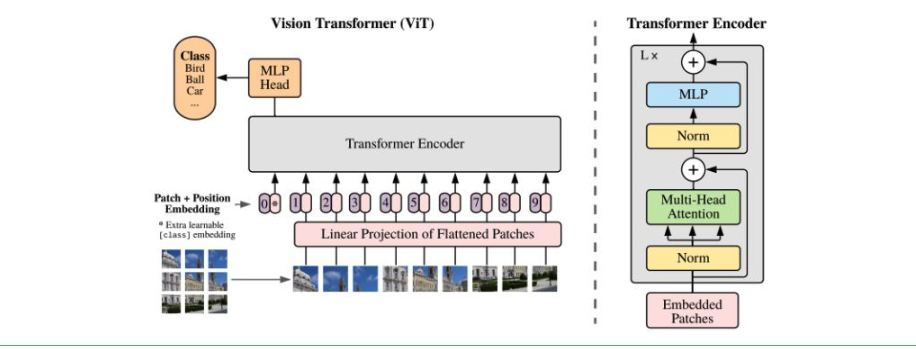

```python
class ViT(nn.Module):
    def __init__(...):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)
```

## 图像分块处理 (make patches)

可以看作是一个图像预处理步骤。在CNN中，直接对图像进行二维卷积处理即可，不需要特殊的预处理流程。但Transformer结构不能直接处理图像，在此之前需要对其进行分块处理。

假设一个图像x∈H×W×C，要将其分成P×P×C的patches，那么实际有$N=HW/P^2$个patches，每个patches的维度为P×P×C。然后将每个patch进行展平，相应的数据维度就为$[N,P^2×C]$。这里N可以理解为输入到Transformer的序列长度，P为图像patch的大小。

## 图像块嵌入 (patch embedding)

所谓图像块嵌入，其实就是对每一个展平后的patch向量做一个线性变换，即全连接层，降维后的维度为D,数据对应的维度从$[N,P^2×C]$变化为$[N,D]$，后续还需要加上一个特殊字符cls，因此最终的维度是$[N+1,D]$。这样就通过patch embedding将一个视觉问题转化为了一个seq2seq问题

In [1]:
import torch
import torch.nn as nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
image_height,image_width = 224,224
patch_height,patch_width = 16,16
channels = 3
dim = 768
num_patches = (image_height // patch_height) * (image_width // patch_width)
patch_dim = channels * patch_height * patch_width

to_patch_embedding = nn.Sequential(
    Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
    nn.Linear(patch_dim, dim),
)

In [2]:
data = torch.randn(8,3,224,224)
x = to_patch_embedding(data)
x.shape

torch.Size([8, 196, 768])

## 位置编码 (position encoding)

除了patch embeddings，模型还需要另外一个特殊的position embedding。transformer和CNN不同，需要position embedding来编码tokens的位置信息，这主要是因为self-attention是permutation-invariant，即打乱sequence里的tokens的顺序并不会改变结果。如果不给模型提供patch的位置信息，那么模型就需要通过patchs的语义来学习拼图，这就额外增加了学习成本。ViT论文中对比了几种不同的position embedding方案(如下），最后发现如果不提供positional embedding效果会差，但其它各种类型的positional embedding效果都接近，这主要是因为ViT的输入是相对较大的patchs而不是pixels，所以学习位置信息相对容易很多。positional embedding的可视化如下图所示：

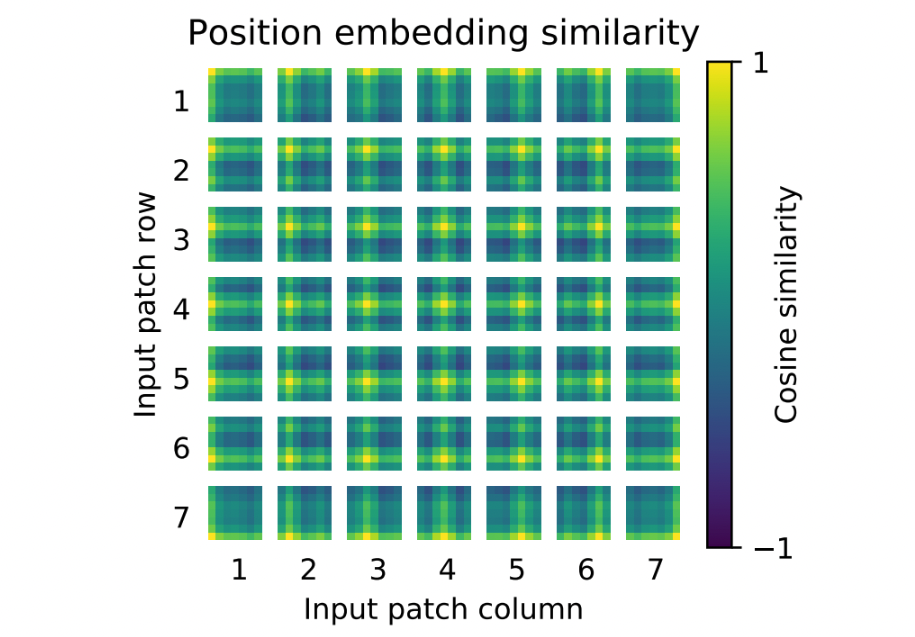

In [3]:
b,n,_ = x.shape
cls_token = nn.Parameter(torch.randn(1, 1, dim))
cls_tokens = repeat(cls_token, '1 1 d -> b 1 d', b = b)
x1 = torch.cat((cls_tokens, x), dim=1)
x1.shape

torch.Size([8, 197, 768])

In [4]:
pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
x1 += pos_embedding[:, :(n + 1)]
x1.shape

torch.Size([8, 197, 768])

## Transformer编码器

获得patch embedding和class token拼接的数据后，将数据输入标准的Transformer Encoder中，Transformer 编码器 由交替的 多头自注意力层 (MSA) 和 多层感知机块 (MLP) 构成。在每个块前用层归一化 (Layer Norm)，在每个块后用残差连接 (Residual Connection)：
- Layer Norm
- Multi-Head Attention
- Dropout/DropPath，在原论文的代码中是直接使用的Dropout层，在但rwightman实现的代码中使用的是DropPath
- MLP Block


In [5]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [7]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [8]:
depth = 6
heads = 16
dim_head = 64
mlp_dim = 2048
dropout = 0.1
transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
out = transformer(x1)
out.shape

torch.Size([8, 197, 768])

## ViT前向流程

  集合了类别向量、图像块嵌入和位置编码三者到一体的输入嵌入向量后，即可传入Transformer Encoder(ViT的 Transformer Encoder通过Transformer Encoder Blocks 串行堆叠而成)，最后提取可学习的类别嵌入向量——class token 对应的特征用于图像分类。ViT的编码器前向计算过程可以归纳如下：

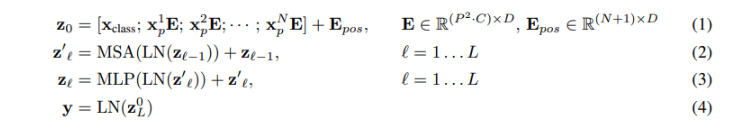

1. 图像块嵌入、类别向量追加和位置编码；
2. 为MSA部分，包括多头自注意力、跳跃连接 (Add) 和层规范化 (Norm) 三个部分，可以重复L个MSA block；
3. 为MLP部分，包括前馈网络 (FFN)、跳跃连接 (Add) 和层规范化 (Norm) 三个部分，也可以重复L个MSA block。
4. 以一个MLP作为分类头 (Classification Head)。

# ConvNext


ConvNext是在ResNet50模型的基础上，仿照Swin Transformer的结构进行改进而得到的纯卷积模型，它对标Swin Transformer，通过一系列实验比对，在相同的FLOPs下，ConvNeXt相比Swin Transformer拥有更快的推理速度以及更高的准确率，在ImageNet 22K上ConvNeXt-XL达到了87.8%的准确率。

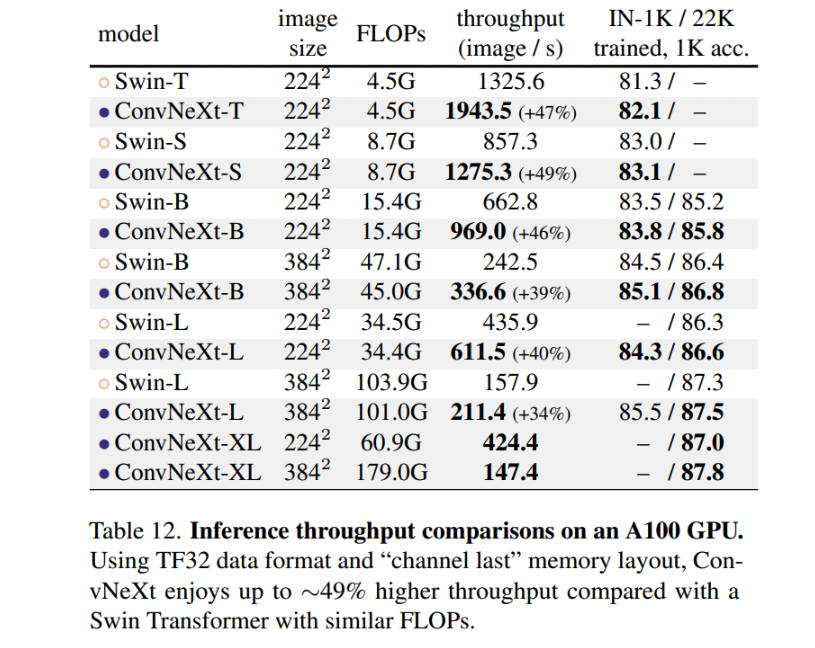

##  ConvNeXt的进化路径

下图概括了ConvNeXt的进化历程，它从ResNet-50或者ResNet-200出发，依次从宏观设计，深度可分离卷积（ResNeXt），逆瓶颈层（MobileNet v2），大卷积核，细节设计这五个角度依次借鉴Swin Transformer的思想，然后在ImageNet-1K上进行训练和评估，最终得到ConvNeXt的核心结构。接下来依次进行介绍。

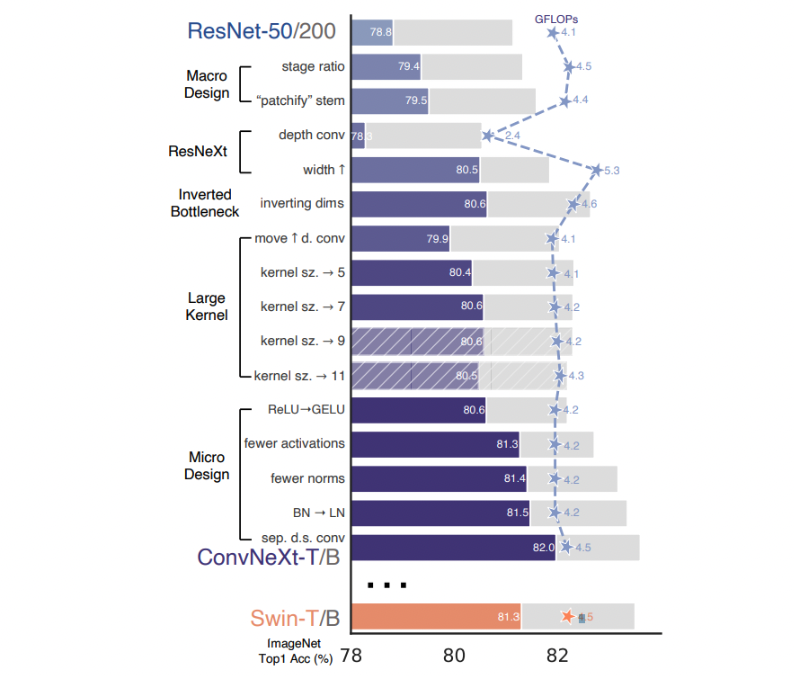

## Macro design

在这个部分作者主要研究两方面：

### Stage Ratio 每个阶段的计算占比

Swin Transfomer和ResNet一样也采用金字塔结构：包含4个stage，每个stage输出不同尺度的特征。这里考虑Swin Transformer和ResNet在宏观设计上的区别，主要有两点：每个stage的计算量占比以及stem cell结构（即stage1之前的模块）。 首先是各个stage的计算量占比，对比ResNet50，4个stage的blocks数量分别是（3，4，6，3），而Swin-T的设置为（2，2，6，2），4个stage的计算量比为1:1:3:1。这里调整ResNet50各个stage的blocks数量以和Swin-T一致：从原来的（3，4，6，3）调整至（3，3，9，3）。调整之后模型性能从78.8%提升至79.4%


### Patchify Stem 第一个卷积层

在之前的卷积神经网络中，最初的下采样模块(stem)一般都是通过一个卷积核大小为7x7步距为2的卷积层以及一个步距为2的最大池化下采样共同组成，高和宽都下采样4倍。但在Transformer模型中一般都是通过一个卷积核非常大且相邻窗口之间没有重叠的（即stride等于kernel_size）卷积层进行下采样。比如在Swin Transformer中采用的是一个卷积核大小为4x4步距为4的卷积层构成patchify，同样是下采样4倍。所以作者将ResNet中的stem也换成了和Swin Transformer一样的patchify。替换后准确率从79.4% 提升到79.5%，GFLOPs从4.5降到4.4%。也有人指出使用覆盖的卷积（例如步长为4，卷积核大小为7的卷积）能够获得更好的表现。

## ResNeXt

相比ResNet，ResNeXt通过采用group conv来提升性能，标准的conv其输入是所有的channels，而group conv会对channels进行分组来减少计算量，这样节省下来的计算量用来增加网络的width即特征channels。对于group conv，其最极端的情况就是每个channel一个group，这样就变成了depthwise conv（简称dw conv），dw conv首先在MobileNet中应用，后来也被其它CNN模型广泛采用。对于dw conv，其和local attention有很多的相似的地方，local attention其实就是对window里的各个token的特征做加权和，而且操作是per-channel的；而dw conv是对kernel size范围的token的特征求加权和，也是分channel的。这里的最大区别就是：self-attention的权重是动态计算的（data dependent），而dw conv的权重就是学习的kernel。

这里将ResNet50中的3x3 conv替换成3x3 dw conv，为了弥补FLOPs的减少，同时将ResNet50的base width从原来的64增加至96（和Swin-T一致，这里的base width是指stem后的特征大小），此时模型的FLOPs有所增加（5.3G），模型性能提升至80.5%。

## 逆瓶颈层

如果把self-attention看成一个dw conv的话（这里忽略self-attention的linear projection操作），那么一个transformer block可以近似看成一个inverted bottleneck，因为MLP等效于两个1x1 conv，并且MLP中间隐含层特征是输入特征大小的4倍（expansion ratio=4）。inverted bottleneck最早在MobileNetV2中提出，随后的EfficientNet也采用了这样的结构。ResNet50采用的是正常的residual bottleneck，这里将其改成inverted bottleneck，即从图（a）变成图（b），虽然dw conv的计算量增加了，但是对于包含下采样的residual block中，用于shortcut的1x1 conv计算量却大大降低，最终模型的FLOPs减少为4.6G。这个变动对ResNet50的准确率从80.5%->80.6%。

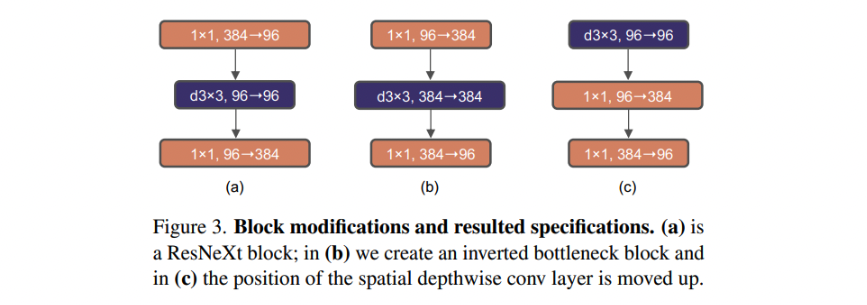

## Large Kernel Sizes

在Transformer中一般都是对全局做self-attention，比如Vision Transformer。即使是Swin Transformer也有7x7大小的窗口。但现在主流的卷积神经网络都是采用3x3大小的窗口，因为之前VGG论文中说通过堆叠多个3x3的窗口可以替代一个更大的窗口，而且现在的GPU设备针对3x3大小的卷积核做了很多的优化，所以会更高效。接着作者做了如下两个改动：

- Moving up depthwise conv layer，即将depthwise conv模块上移，原来是1x1 conv -> depthwise conv -> 1x1 conv，现在变成了depthwise conv -> 1x1 conv -> 1x1 conv。这么做是因为在Transformer中，MSA模块是放在MLP模块之前的，所以这里进行效仿，将depthwise conv上移。这样改动后，准确率下降到了79.9%，同时FLOPs也减小了。
- Increasing the kernel size，接着作者将depthwise conv的卷积核大小由3x3改成了7x7（和Swin Transformer一样），当然作者也尝试了其他尺寸，包括3, 5, 7, 9, 11发现取到7时准确率就达到了饱和。并且准确率从79.9% (3×3) 增长到 80.6% (7×7)。


## 细节优化

经过前面的改动，模型的性能已经提升到80%以上，此时改动后的ResNet50也和Swin-T在整体结构上很类似了，下面开始关注一些微观设计上的差异
### ReLU替换为GELU

ReLU是比较早期的激活函数，近年来更多的模型选择使用GELU作为激活函数，例如ConvNeXt要对齐的Swin Transformer。在ConvNeXt的实验中，GELU并没有提升模型的准确率和效率。但是为了对齐其它指标，ConvNeXt还是选择了GELU作为激活函数。

###  更少的激活函数

在以往的卷积网络中，我们倾向于为每一个卷积操作都添加一个激活函数，但Transformer使用了更少的激活函数，Transformer是由一个自注意力层和两个MLP组成，但它仅在一个MLP上使用了激活函数。

ConvNeXt也借鉴了Transformer的思想，如下图所示，减少后发现准确率从80.6%增长到81.3%

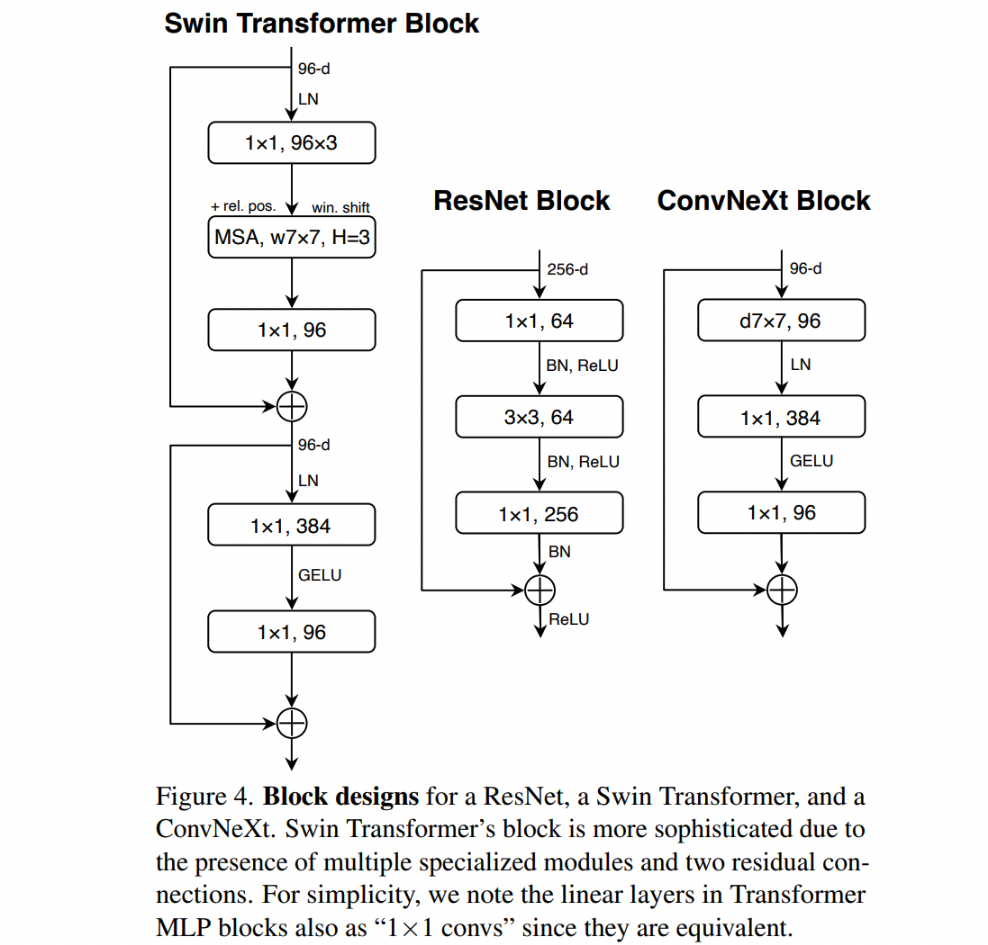

### 更少的归一化层

使用更少的Normalization。同样在Transformer中，Normalization使用的也比较少，接着作者也减少了ConvNeXt Block中的Normalization层，只保留了depthwise conv后的Normalization层。此时准确率已经达到了81.4%，已经超过了Swin-T。


### BN替换为LN
根据之前的经验，BN经常被用在CNN中，而LN通常是用来解决BN在样本量过少的时候归一化统计量偏差过大的问题的。也有实验结果表明，如果将残差网络中的BN直接替换为LN的话，模型的性能反而会下降。

但是在ConvNeXt中，因为之前作者做了若干个将卷积网络向Transformer的改进，因此这里也尝试了将ConvNeXt中的BN替换为LN，令人意外的是，LN在ConvNeXt中要比BN表现的好，它将模型的准确率提升至81.5%。

### 拆分降采样层
在残差网络中，它通常使用的是步长为2 的 3\*3 卷积或者1\*1 卷积来进行降采样，这使得降采样层和其它层保持了基本相同的计算策略。但是Swin Transformer将降采样层从其它运算中剥离开来，即使用一个步长为2的2*2 卷积插入到不同的Stage之间。ConvNeXt也是采用了这个策略，而且在降采样前后各加入了一个LN，而且在全局均值池化之后也加入了一个LN，这些归一化用来保持模型的稳定性。这个策略将模型的准确率提升至82.0%


# 作业

在kaggle的[image-classification](https://www.kaggle.com/competitions/boolart-image-classification)上，利用Timm库，使用`vit_small_patch32_224`, `convnext_small` 两种模型（加载预训练权重）完成训练并提交结果，将模型LB得分截图发送导师，注意Vit和SwinTransformer 图片输入长宽必须与网络要求完全一致，这里两个网络要求的输入尺寸均为`224`。[baseline代码可参考](https://www.kaggle.com/code/qi0239/image-classification-baseline)
